# Group 5 - Metronomy

Team members
1) Nektarios Kalampalikis
2) Vasilis Milionis
3) Tsakoumis Dimitris

In [1]:
from typing import List, Literal

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("data/convex_objects_dataset_large_v02.csv")
meta_df = pd.read_csv("data/convex_objects_metadata.csv")
meta_df.head(1)

,GEOM_NAME,GEOM_TYPE,LateralDensity,DirectionDensity,ExposureTime,X_NOMINAL,X_ACTUAL,X_DEV,Y_NOMINAL,Y_ACTUAL,Y_DEV,Z_NOMINAL,Z_ACTUAL,Z_DEV,RADIUS_NOMINAL,RADIUS_ACTUAL,RADIUS_DEV,DIAMETER_NOMINAL,DIAMETER_ACTUAL,DIAMETER_DEV
0,Sphere 16_extraida,SPH,50,2,0.6,0,0.007447,0.007447,0,-0.000619,-0.000619,0,-0.000979,-0.000979,8.00128,7.97219,-0.02909,16.00256,15.94438,-0.05818


In [3]:
# Fix some missmatch on the GEOM_NAME values
def replace_space(row):
    geom_name_parts = row["GEOM_NAME"].split(' ')
    if row["GEOM_TYPE"] == "SPH" and len(geom_name_parts) == 3:
        row["GEOM_NAME"] = geom_name_parts[0] + " " + geom_name_parts[1] + "_" + geom_name_parts[2]
    return row

meta_df = meta_df.apply(replace_space, axis=1)

# Add an extra column on the metadata that will explicitly define whether the metadata is for extracted or
# constructed data points
meta_df["is_constructed"] = meta_df.apply(lambda row: (len(row["GEOM_NAME"].split('_')) > 1 and row["GEOM_NAME"].split('_')[1] == "construida")
                                          or row["GEOM_NAME"].split(' ')[0] == "Constructed", axis=1)

In [4]:
# Extract each recorded shape that can be found in the metadata df
temp_df = df.copy()
constructed_spheres: List[pd.DataFrame] = []
extracted_spheres: List[pd.DataFrame] = []
constructed_cylinders: List[pd.DataFrame] = []
extracted_cylinders: List[pd.DataFrame] = []
for idx, row in meta_df.iterrows():
  # Ignore rows in the metadata that refer to constructed objects, since we
  # take care of them, when handling the extracted objects (extracted are the real data)
  if row["is_constructed"]:
    continue
  #each sphere has its scanning properties, we check that we have the sphere with the right scanning properties
  partial_indexing = (temp_df["LateralDensity"] == row["LateralDensity"]) &\
                     (temp_df["DirectionDensity"] == row["DirectionDensity"]) &\
                     (temp_df["ExposureTime"] == row["ExposureTime"])
  #because the real data are only the points.We group by the points by the nominal_half_dimension
  shape_df = temp_df[partial_indexing].groupby("NominalHalfDimension")
  # SPH GEOM_TYPE are stored after CYL inside the convex_objects_dataset, thus we need to access the last group
  # found in temp_df first.
  shape_df = shape_df.get_group((list(shape_df.groups)[-1]))
  # shape_df at this point contains both constructed and extracted shapes.
  # we will split the shape_df to 2 equal parts.
  # HOW? The indexes that are even are considered as points for the constructed shapes
  # and the indexes that are odd are considered as points for the extracted shapes
  #Constructed sphere is a df list, each df in the list has the data for only one object
  #We index %2==0 because extracted are odd and constructed are even
  (constructed_spheres if row["GEOM_TYPE"] == "SPH" else constructed_cylinders).append(shape_df[shape_df.reset_index().index % 2 == 0])
  (extracted_spheres if row["GEOM_TYPE"] == "SPH" else extracted_cylinders).append(shape_df[shape_df.reset_index().index % 2 != 0])
  temp_df.drop(shape_df.index, axis=0, inplace=True)

# Make sure you have extracted all shapes that are found in the metadata file
assert(len(constructed_spheres+extracted_spheres+constructed_cylinders+extracted_cylinders) == len(meta_df))

In [5]:
# Create a function that will plot the shapes
def plotme(column_values: list): #sphere1: pd.DataFrame,
    fig = plt.figure(figsize=(19.2, 10.8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    pc = ax.scatter(column_values[0], column_values[1], column_values[2], s=10)
    # ax.set_title('Actual', fontsize=22)
    ax.set_xlabel('X (mm)', fontsize=18)
    ax.set_ylabel('Y (mm)', fontsize=18)
    ax.set_zlabel('Z (mm)', fontsize=18)
    ax.view_init(elev=70, azim=-70)
    plt.show()

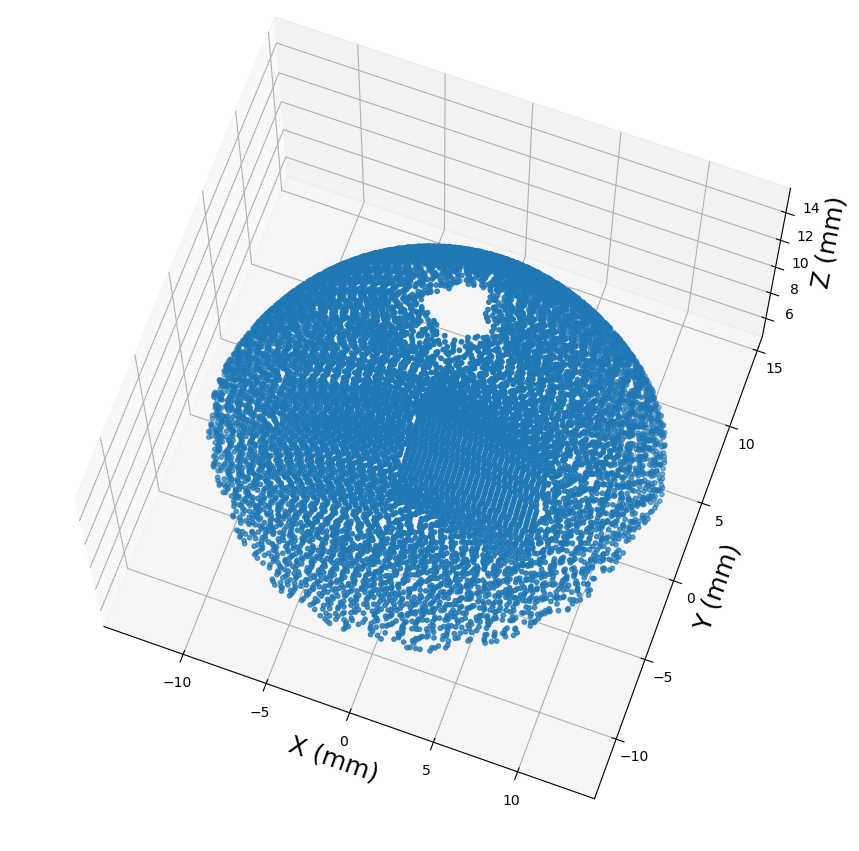

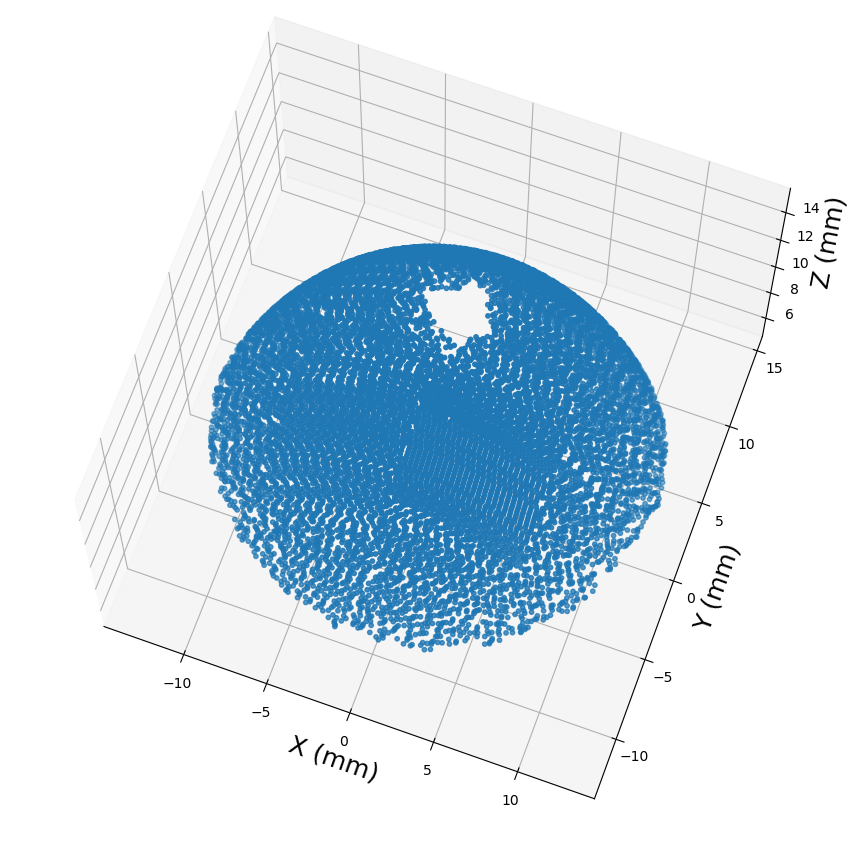

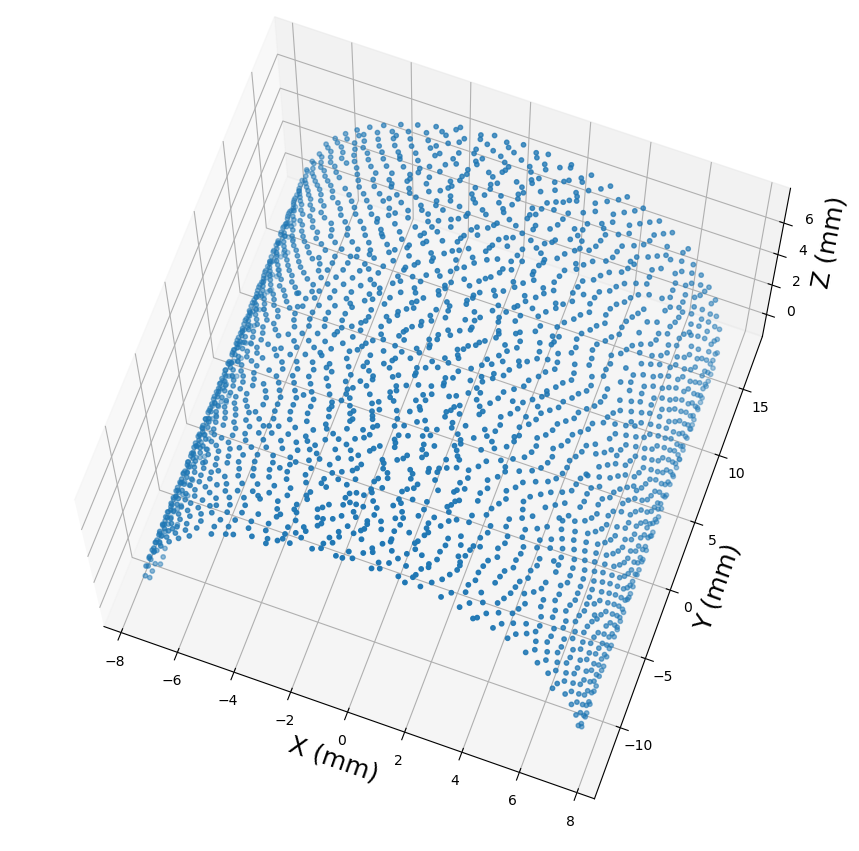

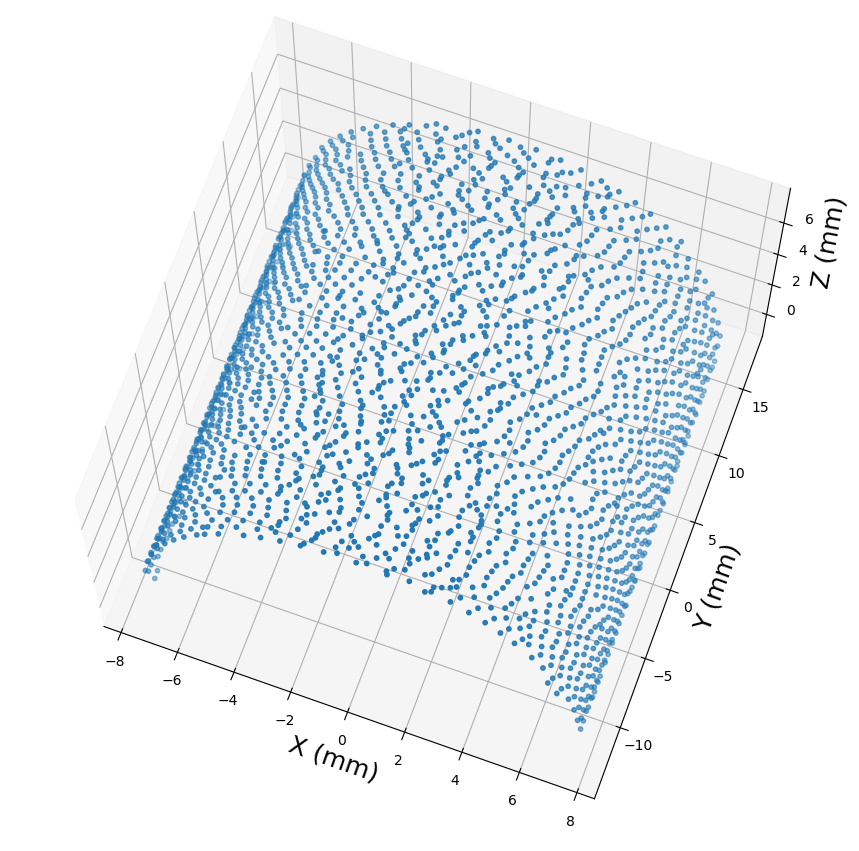

In [6]:
sphere1 = constructed_spheres[0]
sphere2 = extracted_spheres[0]
cylinder1 = constructed_cylinders[0]
cylinder2 = extracted_cylinders[0]
plotme([sphere1.Xref.values, sphere1.Yref.values, sphere1.Zref.values])
plotme([sphere2.Xref.values, sphere2.Yref.values, sphere2.Zref.values])
plotme([cylinder1.Xref.values, cylinder1.Yref.values, cylinder1.Zref.values])
plotme([cylinder2.Xref.values, cylinder2.Yref.values, cylinder2.Zref.values])

In [7]:
constructed_spheres[0]

,NominalHalfDimension,Xref,Yref,Zref,R,X,Y,Z,LateralDensity,DirectionDensity,...,IncidenceCosine,Angle4Quadrant,ViewingCosine,Jcmos,CMOS2surfaceY,Distance2source,Rdev,Xdev,Ydev,Zdev
1288003,15.00425,-12.921480,0.536726,7.607549,14.954807,-12.87890,0.534957,7.58248,50,2,...,0.530278,1.011867,0.493793,0.501064,-0.456981,82.392451,-0.049443,-0.042580,-0.001769,-0.025069
1288005,15.00425,-12.852361,-0.481449,7.727390,14.926195,-12.78550,-0.478944,7.68719,50,2,...,0.539170,5.281840,0.474148,0.501064,-0.518732,82.272610,-0.078055,-0.066861,-0.002505,-0.040200
1288007,15.00425,-8.034914,-7.082406,10.507483,14.956867,-8.00954,-7.060040,10.47430,50,2,...,0.700545,0.794636,0.413814,0.501064,-0.976601,79.492517,-0.047383,-0.025374,-0.022366,-0.033183
1288009,15.00425,-7.453861,-6.718621,11.154712,14.973027,-7.43835,-6.704640,11.13150,50,2,...,0.743986,0.731781,0.464657,0.501064,-0.949738,78.845288,-0.031223,-0.015511,-0.013981,-0.023212
1288011,15.00425,-8.091157,-6.719922,10.700624,14.966779,-8.07095,-6.703140,10.67390,50,2,...,0.712826,5.505909,0.438741,0.501064,-0.945392,79.299376,-0.037471,-0.020207,-0.016782,-0.026724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313561,15.00425,8.141922,9.566753,8.204503,14.968016,8.12226,9.543650,8.18469,50,2,...,0.549845,0.988618,0.775357,0.501064,0.133943,81.795497,-0.036234,-0.019662,-0.023103,-0.019813
1313563,15.00425,8.859851,9.091459,7.998495,14.959031,8.83315,9.064060,7.97439,50,2,...,0.538978,5.281612,0.751799,0.501064,0.102968,82.001505,-0.045219,-0.026701,-0.027399,-0.024105
1313565,15.00425,8.178725,9.086008,8.699451,14.972944,8.16166,9.067050,8.68130,50,2,...,0.576454,0.956414,0.786439,0.501064,0.105507,81.300549,-0.031306,-0.017065,-0.018958,-0.018151
1313567,15.00425,7.593283,8.679777,9.598492,14.958758,7.57026,8.653460,9.56939,50,2,...,0.632414,0.886131,0.828704,0.501064,0.088131,80.401508,-0.045492,-0.023023,-0.026317,-0.029102


In [8]:
def discritize(shape: pd.DataFrame,
               num_bins: int,
               option: Literal["mean", "none"],
               keep_factor: int = 2
    ) -> pd.DataFrame:
    cp_shape = shape.copy()
    # Discretize the 'Xref' feature using cut() with the specified number of bins
    cp_shape['X_discretized'], bins = pd.cut(cp_shape['Xref'], bins=num_bins, retbins=True, labels=False)
    # Calculate the mean values for each bin
    bin_means = [cp_shape['Xref'][(cp_shape['X_discretized'] == i)].mean() for i in range(num_bins)]
    # Assign the mean values to the discretized feature column
    cp_shape['X_discretized'] = cp_shape['X_discretized'].replace(dict(enumerate(bin_means)))
    if option == "mean":
        return cp_shape
    
    # Get the bin edges
    bin_edges = bins.tolist()

    # Create a list to store the indices of rows to be deleted
    rows_to_delete = []

    # Iterate over the even-indexed bins (starting from index 1)
    for i in range(1, len(bin_edges)):
        # Get the bin edges for the current even-indexed bin
        bin_start = bin_edges[i - 1]
        bin_end = bin_edges[i]
        
        # Find the indices of rows within the current bin range and add them to the list
        if i % keep_factor == 0:
            continue
        rows_to_delete.extend(cp_shape[(cp_shape['X'] >= bin_start) & (cp_shape['X'] <= bin_end)].index)

    # Delete the rows from the DataFrame
    cp_shape = cp_shape.drop(rows_to_delete)

    # Reset the index if needed
    cp_shape = cp_shape.reset_index(drop=True)
    return cp_shape

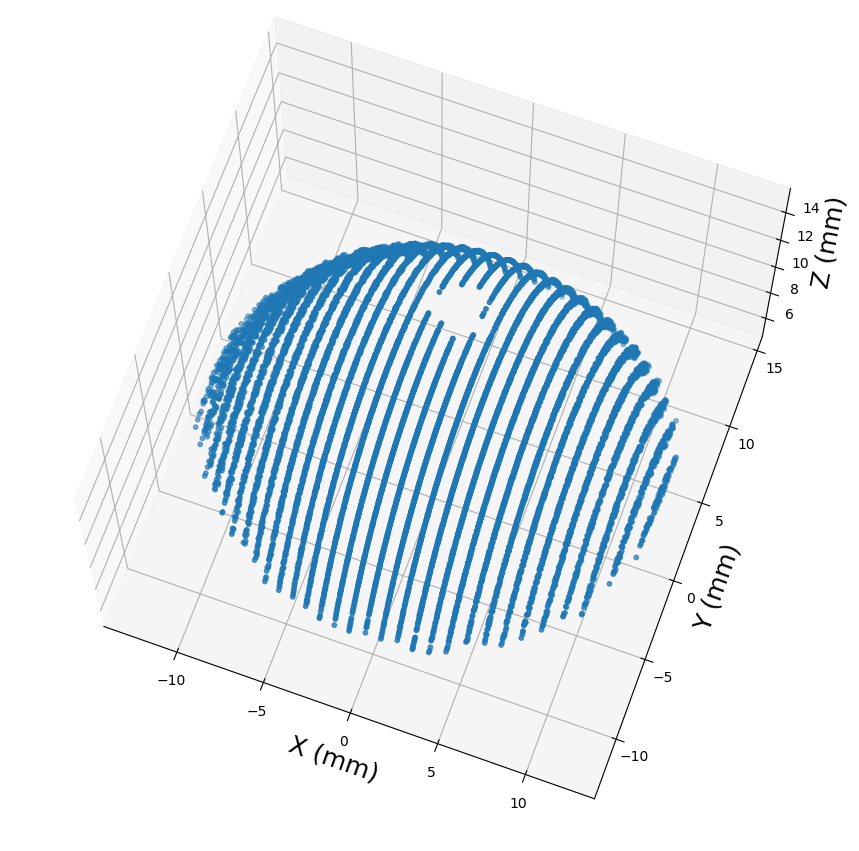

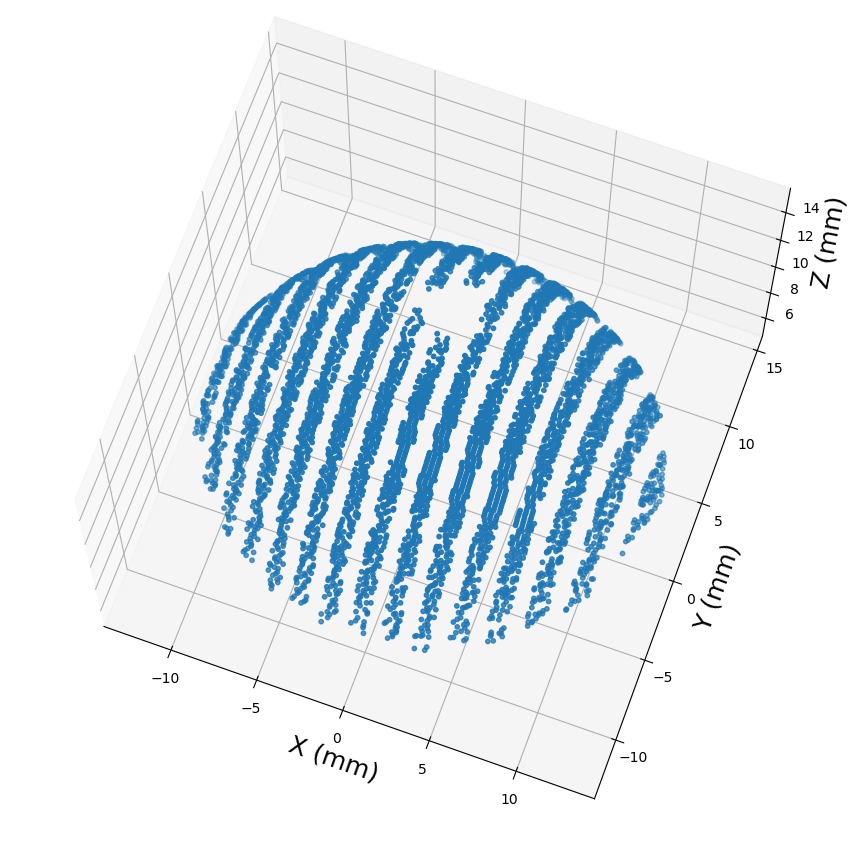

In [9]:
num_bins = 30
keep_factor = 2
#keep only the mean of the bins -- VISUAL ONLY
mean_df = discritize(constructed_spheres[0], num_bins, 'mean', keep_factor=keep_factor)
plotme([mean_df.X_discretized.values, mean_df.Yref.values, mean_df.Zref.values])
#keep only the points in bins 
discr_df = discritize(constructed_spheres[0], num_bins, 'none', keep_factor=keep_factor)
plotme([discr_df.Xref.values, discr_df.Yref.values, discr_df.Zref.values])

In [10]:
def discritize_merge_shapes(df: pd.DataFrame, keep_factor: int):
    # Merge all lists of shapes
    merged_shapes = constructed_cylinders + extracted_cylinders + constructed_spheres + extracted_spheres
    # Update the Scan Direction Density
    df["DirectionDensity"] = df["DirectionDensity"].apply(lambda x: x*keep_factor)
    # Add all points from all different shapes into one merged dataframe
    # while at the same time discritizing each shape
    merged_df = pd.DataFrame(columns=constructed_spheres[0].columns)
    for shape in merged_shapes:
        # Fix the Direction Density value
        shape["DirectionDensity"] = shape["DirectionDensity"].apply(lambda x: x*keep_factor)
        # Downsample the shape
        temp_shape = discritize(shape, num_bins, 'none', keep_factor=keep_factor)
        # Add the points to a merged dataframe
        merged_df = pd.concat([merged_df, temp_shape], axis=0, ignore_index=True)
    return merged_df

In [11]:
merged_df = discritize_merge_shapes(df, keep_factor)

C:\Users\maria\AppData\Local\Temp\ipykernel_8744\4187379980.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape["DirectionDensity"] = shape["DirectionDensity"].apply(lambda x: x*keep_factor)
C:\Users\maria\AppData\Local\Temp\ipykernel_8744\4187379980.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape["DirectionDensity"] = shape["DirectionDensity"].apply(lambda x: x*keep_factor)


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

test_df = pd.merge(df, merged_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

## split the class into 4 groups, one for each target
merged_df.drop("X_discretized",axis=1,inplace=True)
features = merged_df.columns[8:-4]     
targets = merged_df.columns[-4:]      

## group A => target=targets[0] (Rdev)
## group B => target=targets[1] (Xdev)
## group C => target=targets[2] (Ydev)
## group D => target=targets[3] (Zdev)
target = targets[1]
print(target)
print(features)

X_binned = merged_df[features]
Y_binned = merged_df[target]

Xtest = test_df[features]
Ytest = test_df[target]

## scale features & target
# scalerX = MinMaxScaler()
# scalerY = MinMaxScaler()
# Xsc = scalerX.fit_transform(X)
# Ysc = scalerY.fit_transform(Y)

Xdev
Index(['LateralDensity', 'DirectionDensity', 'ExposureTime', 'Nx', 'Ny', 'Nz',
       'Laser2surfaceX', 'Laser2surfaceY', 'Laser2surfaceZ', 'IncidenceCosine',
       'Angle4Quadrant', 'ViewingCosine', 'Jcmos', 'CMOS2surfaceY',
       'Distance2source'],
      dtype='object')


In [13]:
## split the data into train and test sets
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xsc, Ysc, test_size=0.2, random_state = 42)
Xtrain, Ytrain = X_binned, Y_binned

In [15]:
## optimal models' hyper-parameters
hparams = {'max_depth' : 3, 'random_state' : 1}

model = DecisionTreeRegressor(**hparams)

model.fit(Xtrain, Ytrain.ravel())
scores = cross_val_score(model, Xtrain, Ytrain.ravel(), cv=3, n_jobs=-1)

In [16]:
print("Mean validation R2_score = ", np.mean(scores), " +- ", np.std(scores))

Mean validation R2_score =  0.15521342736985652  +-  0.01568594331970942


In [17]:
tree_predictions = model.predict(Xtest)
mae = metrics.mean_absolute_error(Ytest.values.ravel(), tree_predictions)
r2 = metrics.r2_score(Ytest.values.ravel(), tree_predictions)

In [18]:
#print("Test R2_score = ", np.round(r2, 2))
print("Test MAE = ", np.round(mae, 3), " mm")

Test MAE =  0.012  mm


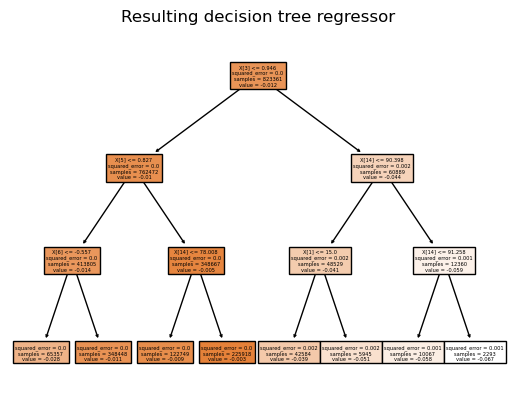

In [19]:
from sklearn.tree import plot_tree

plt.figure()
plot_tree(model, filled=True)
plt.title("Resulting decision tree regressor")
plt.show()

In [20]:
from sklearn.tree import export_text
r = export_text(model, feature_names=model.feature_names_in_.tolist())
print(r)

|--- Nx <= 0.95
|   |--- Nz <= 0.83
|   |   |--- Laser2surfaceX <= -0.56
|   |   |   |--- value: [-0.03]
|   |   |--- Laser2surfaceX >  -0.56
|   |   |   |--- value: [-0.01]
|   |--- Nz >  0.83
|   |   |--- Distance2source <= 78.01
|   |   |   |--- value: [-0.01]
|   |   |--- Distance2source >  78.01
|   |   |   |--- value: [-0.00]
|--- Nx >  0.95
|   |--- Distance2source <= 90.40
|   |   |--- DirectionDensity <= 15.00
|   |   |   |--- value: [-0.04]
|   |   |--- DirectionDensity >  15.00
|   |   |   |--- value: [-0.05]
|   |--- Distance2source >  90.40
|   |   |--- Distance2source <= 91.26
|   |   |   |--- value: [-0.06]
|   |   |--- Distance2source >  91.26
|   |   |   |--- value: [-0.07]



In [21]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(Xtest, Ytest)
eli5.show_weights(perm, feature_names = Xtest.columns.tolist())

Weight,Feature
0.1842 ± 0.0019,Nz
0.0701 ± 0.0006,Laser2surfaceX
0.0173 ± 0.0001,Distance2source
0.0033 ± 0.0001,Nx
0.0001 ± 0.0000,DirectionDensity
0 ± 0.0000,CMOS2surfaceY
0 ± 0.0000,Jcmos
0 ± 0.0000,ViewingCosine
0 ± 0.0000,Angle4Quadrant
0 ± 0.0000,IncidenceCosine


In [22]:
import shap
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(Xtest, Ytest)

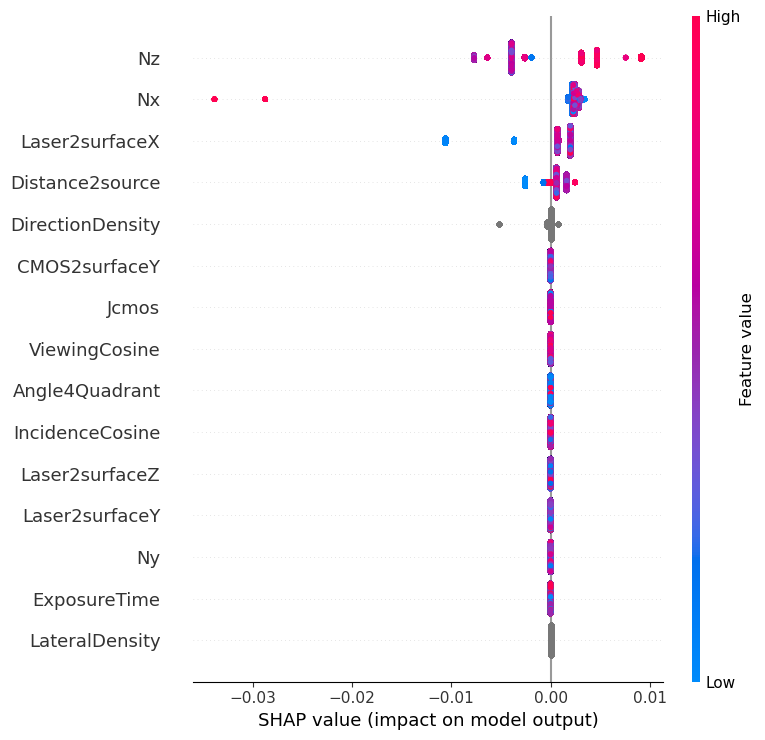

In [23]:
shap.summary_plot(shap_values, Xtest, feature_names=features)